# Food Cost Prediction Model Experiments

#### Experiments by Grace Ivey and Sydney Balboni

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Visualization

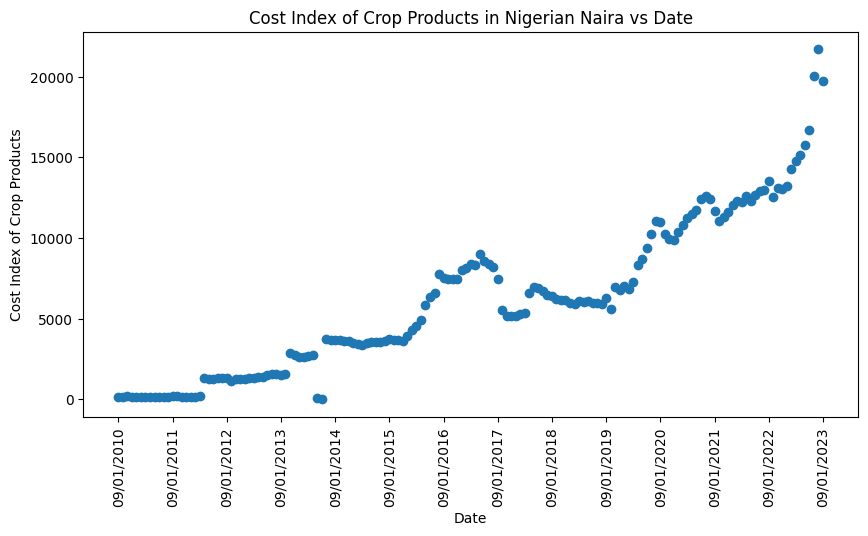

In [2]:
# Load cleaned data
df = pd.read_csv('cleaned_cost_index_of_crop_products_nigerian_naira.csv')

# Vizualize the data
plt.figure(figsize=(10, 5))
plt.title('Cost Index of Crop Products in Nigerian Naira vs Date')
plt.scatter(df['Date'], df['Cost Index of Crop Products in Nigerian Naira'])
plt.xlabel('Date')
plt.xticks(df['Date'][::12], rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Cost Index of Crop Products')
plt.show()

## Linear Regression
#### Data Loading for Linear Regression

In [3]:
# Shuffle the DataFrame
# df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Split data into features (X) and target (y)
# X is the list of indices of the crop products
X = df.index.tolist()
y = df['Cost Index of Crop Products in Nigerian Naira'].values

# Split the dataset into training and test sets
# 80% of the data will be used for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)


#### Run the Linear Regression Model

In [4]:
# Run the model
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
y_predict = lin_model.predict(x_test)

# Calculate Mean Squared Error
mse_lin_reg = mean_squared_error(y_test, y_predict)
print(f"Mean Squared Error: {mse_lin_reg}")

# Calculate Mean Absolute Error
mae_lin_reg = mean_absolute_error(y_test, y_predict)
print(f"Mean Absolute Error: {mae_lin_reg}")

# Calculate R-squared
r_squared_lin_reg = r2_score(y_test, y_predict)
print(f"R-squared: {r_squared_lin_reg}")

Mean Squared Error: 3543976.8358316636
Mean Absolute Error: 1145.89095754008
R-squared: 0.870835295514963


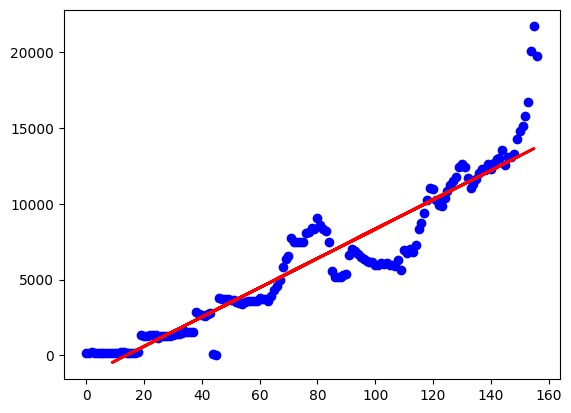

In [5]:
# Plot the regression line and data
plt.scatter(X, y, color='blue')
plt.plot(x_test, y_predict, color='red', linewidth=2)
plt.show()


## Transformer
#### Data Loading for Transformer

In [6]:
data = df['Cost Index of Crop Products in Nigerian Naira'].values

# Make sequence for transformer to learn from
sequence_length = 100
sequences = []
next_values = []

for i in range(sequence_length, len(data)):
    sequences.append(data[i - sequence_length:i])  
    next_values.append(data[i]) 

x_train, x_test, y_train, y_test = train_test_split(
    sequences, next_values, test_size=0.2
)

In [7]:
# Scaler for scaling the data
scaler = StandardScaler()

# Scale the x_train and x_test
x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, sequence_length)).reshape(-1, sequence_length, 1)
x_test_scaled = scaler.transform(np.array(x_test).reshape(-1, sequence_length)).reshape(-1, sequence_length, 1)

# Scale the y_train and y_test 
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

In [8]:
# Form tensors from the data
# Data needs to be in tensors for the model to ingest
x_train_tensor = tf.convert_to_tensor(x_train_scaled, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test_scaled, dtype=tf.float32)

#### Model Definition

In [9]:
# Transformer Model 
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res  

#### Model Implementation

In [10]:
# Define positional encoding function
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

In [11]:
# Model parameters
head_size = 64
num_epochs = 200
batch_size = 32
num_heads = 16
ff_dim = 16

d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

# Define the input layer
inputs = tf.keras.Input(shape=(sequence_length, d_model))

# Add positional encoding to the input
# The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
# Not including the positional encoding is basically the same as randomizing the order of the data
x = inputs + positional_encoding(sequence_length, d_model) 

# Transformer Encoder
x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim)

# Global Average Pooling layer
# The Global Average Pooling layer reduces the dimensionality of the data
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 1)]             0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 100, 1)               0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 100, 1)               2         ['tf.__operators__.add[0][0]']
 Normalization)                                                                                   
                                                                                              

#### Train the Transformer

In [13]:
# Train the model
model.fit(x_train_tensor, y_train_tensor, epochs=num_epochs, batch_size=batch_size, verbose=0)

#### Validate the Transformer on Test Data

In [14]:
# Predictions and Inverse Transform
y_pred_scaled = model.predict(x_test_tensor)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform the actual test data
y_test_inverse = scaler.inverse_transform(y_test_scaled)

# Calculate performance metrics using the inverse transformed values
mse_transformer = mean_squared_error(y_test_inverse, y_pred)
mae_transformer = mean_absolute_error(y_test_inverse, y_pred)
r_squared_transformer = r2_score(y_test_inverse, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse_transformer}")
print(f"Mean Absolute Error: {mae_transformer}")
print(f"R-squared: {r_squared_transformer}")

1/1 [==============================] - 0s 339ms/step
Mean Squared Error: 19432668.63777579
Mean Absolute Error: 3461.5026877604164
R-squared: -0.20339317657079548


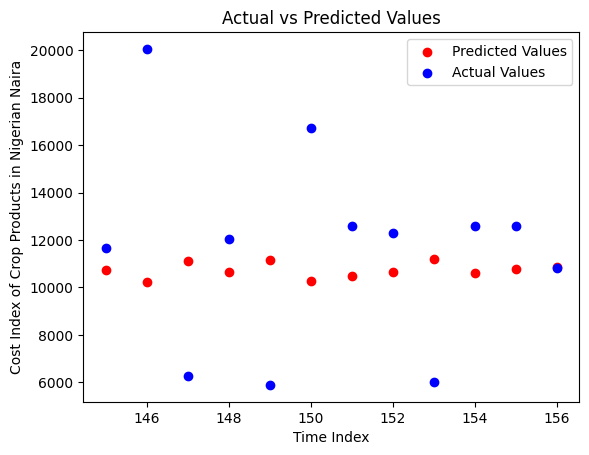

In [15]:
# Plot the prediction result
dates = df.index[-len(y_test):] 
plt.scatter(dates, y_pred, color='red', label='Predicted Values')
plt.scatter(dates, y_test, color='blue', label='Actual Values') 
plt.xlabel('Time Index')
plt.ylabel('Cost Index of Crop Products in Nigerian Naira')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Comparison of the Linear Regression and Transformer Results

In [16]:
# Compare the results of the linear regression model and the transformer model
print(f"Linear Regression R-squared: {r_squared_lin_reg}")
print(f"Transformer R-squared: {r_squared_transformer}")
print()
print(f"Linear Regression Mean Squared Error: {mse_lin_reg}")
print(f"Transformer Mean Squared Error: {mse_transformer}")
print()
print(f"Linear Regression Mean Absolute Error: {mae_lin_reg}")
print(f"Transformer Mean Absolute Error: {mae_transformer}")

Linear Regression R-squared: 0.870835295514963
Transformer R-squared: -0.20339317657079548

Linear Regression Mean Squared Error: 3543976.8358316636
Transformer Mean Squared Error: 19432668.63777579

Linear Regression Mean Absolute Error: 1145.89095754008
Transformer Mean Absolute Error: 3461.5026877604164


## Transformer Hyperparameter Experiments